 # **Exemplo 3: Variational Quantum Eigensolver**
 ## Neste exemplo vamos usar o Variational Quantum Eigensolver para encontrar o estado fundamental da molécula $H_2$
 * ### Como no exemplo 2, vamos seguir o artigo Du J., Xu N., Peng X., Wang P., Wu S., Lu D. Phys. Rev. Lett., 104, 030502 (2010)

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, providers
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools import *
from qiskit.providers.aer  import  noise
from ibm_quantum_widgets import *
from qiskit.result import QuasiDistribution
from qiskit.extensions import UnitaryGate
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit.circuit.library import QFT
from qiskit.circuit.add_control import add_control
from qiskit.quantum_info.synthesis import OneQubitEulerDecomposer
from qiskit.circuit import Parameter
# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum",token = '9fa79efa2b5d81d9ca1d5c9f33493ebc19df76d34ba3efeffff31dfce86bf83d7f0e6c527ecb4caaeb34835a429c49ad23f6ed9dc89029dabc2b73786b966663' )

# Python libraries
import matplotlib.pyplot as plt
import scipy as sc
import numpy as np
import time 
from  functools import partial

* O circuito deve conter um ansatz para preparar o estado fundamental $|\psi_0\rangle$.
* Precisamos também medir o valor médio da energia $ \langle \psi_0| H |\psi_0\rangle$, para isso vamos decompor a Hamiltoniana em matrizes de pauli:
$H = \begin{pmatrix}
-1.8310 & 0.1813 \\
0.1813 & -0.2537 
\end{pmatrix} = -1.04235 I + 0.1813 X -0.78865 Z$.

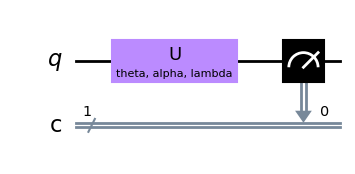

In [2]:
#Ansatz ####################
aux = QuantumRegister(1,'q')

c = ClassicalRegister(1,'c')

circ = QuantumCircuit(aux,c)

theta = Parameter('theta')
phi = Parameter('alpha')
lamb =  Parameter('lambda')

circ.u(theta,phi,lamb,aux)

circ.measure(aux,c)

display(circuit_drawer(circ, output='mpl'))

# Hamiltoniana
#------------------------------------------------------------------------------
h = SparsePauliOp.from_list([("Z", -0.78865), ("X",  0.1813), ("I",   -1.04235)])
#------------------------------------------------------------------------------

* ### Vamos agora construir a função custo.

In [3]:
#função custo
def cost_func(params, ansatz, hamiltonian, estimator):
    # params - parâmetros do circuto para minimizar
    # ansatz - circutio ansatz
    # Hamiltoniana 
    # estimador
    energy = ( estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0] )
    return energy

* ### Vamos agora simular o VQE com algoritmos de minimização do scipy

In [4]:
backend = service.backend("ibmq_qasm_simulator")

options = Options()
    
options.resilience_level = 1
    
options.execution.shots = 2048

est = Estimator(session=backend, options=options)

#compilação dos circuitos
optimized_circ = transpile(circ,backend = backend,  optimization_level = 3)

# Chute inicial
x0 = 2 * np.pi * np.random.random(3)

from scipy.optimize import minimize

#função para guardar as iteraçõs e monitorar o andamento da minimização
iteractions =[]
fun_values = []
def callback(current_vector, ansatz = optimized_circ, hamiltonian =h, estimator =est):
    current_energy = estimator.run(ansatz, hamiltonian, parameter_values=current_vector).result().values[0]
    fun_values.append(current_energy)
    iteractions.append(len(fun_values)) 
    print("Iters. done: " +  str(max(iteractions)) + " Current Energy = "  + str(current_energy) , end="\r")      

with Session(service=service, backend= backend) as session:
    res = minimize(cost_func, x0, args=(optimized_circ, h, est), method="cobyla", callback = callback, options ={'maxiter': 50})
    session.close()
    
print(res.message + "The final solution is " + str(res.fun) , end="\r")

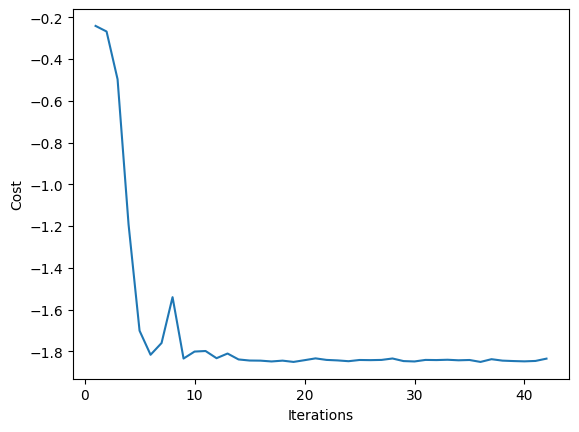

In [5]:
fig, ax = plt.subplots()
ax.plot(iteractions, fun_values)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost");

### Simulação com ruído

In [6]:
#Vamos esoclher o computador Manila e importar suas caracteristicas
from qiskit.providers.fake_provider import FakeManila
fake_backend = FakeManila()
# Modelo de ruído para o Manila
noise_model = noise.NoiseModel.from_backend(fake_backend)

# Opções para simualção com ruído.  
options_noise = Options()
options_noise.execution.shots = 2048
options_noise.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
}
    
options.resilience_level = 1

est_noise = Estimator(session=backend, options=options)

#compilação dos circuitos
optimized_circ = transpile(circ,backend = backend,  optimization_level = 3)

#função para guardar as iteraçõs e monitorar o andamento da minimização
iteractions_noise =[]
fun_values_noise = []
def callback(current_vector, ansatz = optimized_circ, hamiltonian =h, estimator =est):
    current_energy = estimator.run(ansatz, hamiltonian, parameter_values=current_vector).result().values[0]
    fun_values_noise.append(current_energy)
    iteractions_noise.append(len(fun_values_noise)) 
    print("Iters. done: " +  str(max(iteractions_noise)) + " Current Energy = "  + str(current_energy) , end="\r")      

with Session(service=service, backend= backend) as session:
    res = minimize(cost_func, x0, args=(optimized_circ, h, est), method="cobyla", callback = callback, options ={'maxiter': 50})
    session.close()
       
print(res.message + "The final solution is " + str(res.fun) , end="\r")

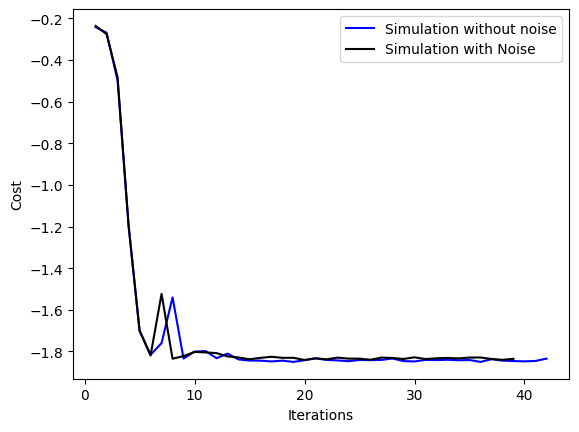

In [7]:
fig, ax = plt.subplots()
ax.plot(iteractions, fun_values,'b',iteractions_noise, fun_values_noise,'k')
ax.legend(['Simulation without noise','Simulation with Noise'])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost");

### Usando VQE no pacote qiskit.algorithms.minimum_eigensolvers

In [8]:
from qiskit.algorithms.minimum_eigensolvers import VQE

optimizer = partial(minimize, method="cobyla",options = {'maxiter':50})

backend = service.backend("ibmq_qasm_simulator")

options = Options()
    
options.resilience_level = 1
    
options.execution.shots = 2048

est = Estimator(session=backend, options=options)

#compilação dos circuitos
optimized_circ = transpile(circ,backend = backend,  optimization_level = 3)

# Chute inicial
x0 = 2 * np.pi * np.random.random(3)

counts = []
values = []
def callback(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        print("Iters. done: " +  str(max(counts)) + " Current Energy = "  + str(mean) , end="\r")       

vqe = VQE(ansatz = optimized_circ, optimizer = optimizer, initial_point = x0, estimator = est, callback=callback )

result=vqe.compute_minimum_eigenvalue(operator = Operator(h))

print(result.optimizer_result['message'] +  "  Energy = "  + str(result.optimizer_result['fun']) , end="\r")

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method cobyla cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


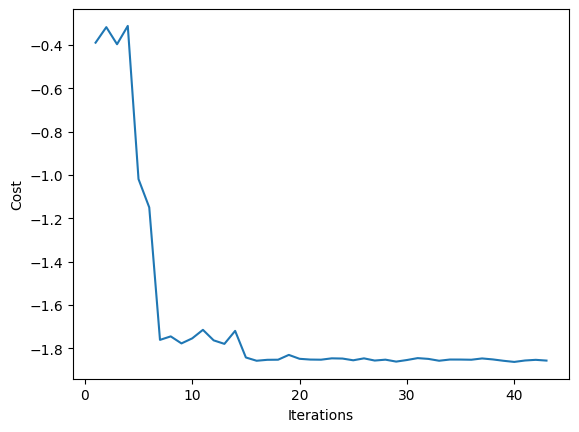

In [9]:
fig, ax = plt.subplots()
ax.plot(counts, values)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost");

In [11]:
backend = service.backend('ibm_manila')

options = Options()
    
options.resilience_level = 1
    
options.execution.shots = 2048

est = Estimator(session=backend, options=options)

#compilação dos circuitos
optimized_circ = transpile(circ,backend = backend,  optimization_level = 3)

# Hamiltoniana
#------------------------------------------------------------------------------
h = SparsePauliOp.from_list([("IIIZI", -0.78865), ("IIIXI",  0.1813), ("IIIII",   -1.04235)])
#------------------------------------------------------------------------------

counts_real = []
values_real = []
def callback(eval_count, parameters, mean, std):
        counts_real.append(eval_count)
        values_real.append(mean)
        print("Iters. done: " +  str(max(counts)) + " Current Energy = "  + str(mean) , end="\r")       

vqe = VQE(ansatz = optimized_circ, optimizer = optimizer, initial_point = x0, estimator = est, callback=callback )

result=vqe.compute_minimum_eigenvalue(operator = Operator(h))

print(result.optimizer_result['message'] +  "  Energy = "  + str(result.optimizer_result['fun']) , end="\r")

Traceback (most recent call last):
  Cell In[11], line 28
    result=vqe.compute_minimum_eigenvalue(operator = Operator(h))
  File /opt/conda/lib/python3.10/site-packages/qiskit/algorithms/minimum_eigensolvers/vqe.py:166 in compute_minimum_eigenvalue
    self._check_operator_ansatz(operator)
  File /opt/conda/lib/python3.10/site-packages/qiskit/algorithms/minimum_eigensolvers/vqe.py:313 in _check_operator_ansatz
    raise AlgorithmError(
AlgorithmError: 'The number of qubits of the ansatz does not match the operator, and the ansatz does not allow setting the number of qubits using `num_qubits`.'

Use %tb to get the full traceback.
